## Measuring bias
<br>
Fairness analysis using the adult income dataset.
<br>
Dataset: https://archive.ics.uci.edu/ml/datasets/adult
<br>
<br>
References:
<br>
https://github.com/conorosully/medium-articles/blob/master/src/algorithm%20fairness/Measuring%20Bias.ipynb
<br>
https://drlee.io/fairness-in-machine-learning-analyzing-bias-with-the-adult-census-dataset-4699fe5809da#step-3-prevalence-calculation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

import shap

In [ ]:
# Load the dataset
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/adult-all.csv"

In [ ]:
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'y']

# Load data
df = pd.read_csv(url, header=None, names=names, na_values='?')
df = df.dropna()

In [ ]:
print(len(df))
df.head()

45222


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
#Snap shot of dataset
df[['age','education-num','marital-status','occupation',
    'hours-per-week','native-country',
    'race','sex','y']].head(10)

,age,education-num,marital-status,occupation,hours-per-week,native-country,race,sex,y
0,39,13,Never-married,Adm-clerical,40,United-States,White,Male,<=50K
1,50,13,Married-civ-spouse,Exec-managerial,13,United-States,White,Male,<=50K
2,38,9,Divorced,Handlers-cleaners,40,United-States,White,Male,<=50K
3,53,7,Married-civ-spouse,Handlers-cleaners,40,United-States,Black,Male,<=50K
4,28,13,Married-civ-spouse,Prof-specialty,40,Cuba,Black,Female,<=50K
5,37,14,Married-civ-spouse,Exec-managerial,40,United-States,White,Female,<=50K
6,49,5,Married-spouse-absent,Other-service,16,Jamaica,Black,Female,<=50K
7,52,9,Married-civ-spouse,Exec-managerial,45,United-States,White,Male,>50K
8,31,14,Never-married,Prof-specialty,50,United-States,White,Female,>50K
9,42,13,Married-civ-spouse,Exec-managerial,40,United-States,White,Male,>50K


# Exploratory analysis

In [ ]:
# Basic dataset info
print(df.info())
print('---#--------Volume: Income $50K----#---------')
print(df['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education-num   45222 non-null  int64 
 5   marital-status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital-gain    45222 non-null  int64 
 11  capital-loss    45222 non-null  int64 
 12  hours-per-week  45222 non-null  int64 
 13  native-country  45222 non-null  object
 14  y               45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB
None
---#--------Volume: Income $50K----#---------
y
<=50K    34014
>50K     11208
Name: count, dt

In [ ]:
print("<=50K:", 34014/45222)
print(">50K:", 11208/45222)

<=50K: 0.7521560302507629
>50K: 0.2478439697492371


## Unbalanced datasets

Our fairness analysis will focus on two protected features: **race** and **sex**.  \
Let's take a look at the internal distribution of these features.

Text(0.5, 1.0, 'Sex')

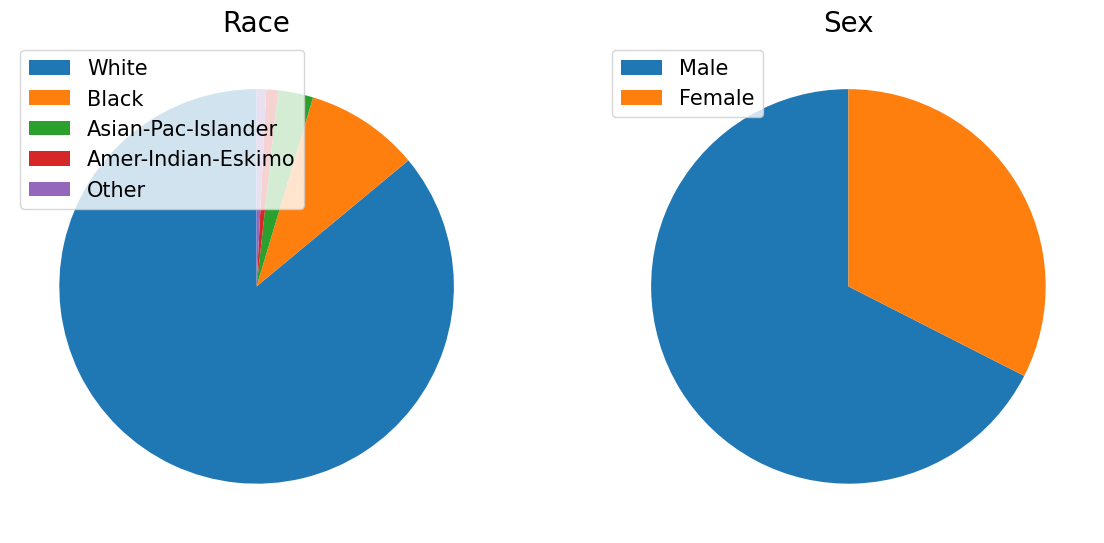

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Plot breakdown by race
counts = df['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

plt.subplot(122)

#Plot breakdown by sex
counts = df['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Sex",size=20)

#plt.tight_layout(pad=2)

## Defining protected features

**Protected features** (in fairness analysis) allow us to measure how different groups are treated by the model. This is important to analyze since certain groups may receive unfair lower-quality predictions, and these can perpetuate inequality.

For this fairness analysis, we define **race** and **sex** as protected features (attributes that are legally or ethically sensitive).

We will consider here:

*   **Race**: White as the privileged group.
*   **Sex**: Male as the privileged group.



We create binary variables to represent the protected features.

In [ ]:
# Get features of interest from dataset
df_fair = df[['age', 'education-num', 'hours-per-week', 'race', 'sex', 'y']]

# Define protected variables
df_fair['priv_race'] = [1 if r=='White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s=='Male' else 0 for s in df_fair['sex']]

# Define target variable
df_fair['y'] =  [1 if y == '>50K'else 0 for y in df['y']]

df_fair.head()

<ipython-input-42-dbb4a8a7a1db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fair['priv_race'] = [1 if r=='White' else 0 for r in df_fair['race']]
<ipython-input-42-dbb4a8a7a1db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fair['priv_sex'] = [1 if s=='Male' else 0 for s in df_fair['sex']]
<ipython-input-42-dbb4a8a7a1db>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,age,education-num,hours-per-week,race,sex,y,priv_race,priv_sex
0,39,13,40,White,Male,0,1,1
1,50,13,13,White,Male,0,1,1
2,38,9,40,White,Male,0,1,1
3,53,7,40,Black,Male,0,0,1
4,28,13,40,Black,Female,0,0,0


In [ ]:
# Drop the original 'race' and 'sex' columns
df_fair = df_fair.drop(columns=['race', 'sex'])

# Now df_fair contains the dataset without 'race' and 'sex' columns
print(df_fair.head())

   age  education-num  hours-per-week  y  priv_race  priv_sex
0   39             13              40  0          1         1
1   50             13              13  0          1         1
2   38              9              40  0          1         1
3   53              7              40  0          0         1
4   28             13              40  0          0         0


## Prevelance

Here we look at **prevalence** which is the proportion of individuals who belong to the <ins>positive</ins> class;\
in our case, these are the individuals who earn more than $50K (y > 50K).

**Prevalence** helps us understand the baseline distribution of <ins>positive</ins> cases across different groups. \
This provides context for understanding whether the model is biased in favour of certain groups.

In [ ]:
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

print(f"Overall Prevalence (Income(y) > 50K): {prev}")
print("---------#----------#------------")
print(f"Prevalence by Race:\n\n {prev_race}")
print("---------#----------#------------")
print(f"Prevalence by Sex:\n\n {prev_sex}")
print("---------#----------#------------")
print("mean y grouped by RACE and SEX: \n\n", prev_comb)

Overall Prevalence (Income(y) > 50K): 0.2478439697492371
---------#----------#------------
Prevalence by Race:

 priv_race
0    0.158411
1    0.262371
Name: y, dtype: float64
---------#----------#------------
Prevalence by Sex:

 priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64
---------#----------#------------
mean y grouped by RACE and SEX: 

 priv_race  priv_sex
0          0           0.076102
           1           0.224408
1          0           0.122444
           1           0.323908
Name: y, dtype: float64


Rememeber, in terms of the target variable, `prevalence` is the proportion of the positive cases to **overall** cases. \
Our dataset has an overall prevalence of 24.8%. That is, about 1/4 of the people in our dataset earn above $50K. We can also use prevalence **as a fairness metric**.

###Question:
What can we learn about the income (y) variable in the above analysis? Do we see any potential inequalities/bias present in the data?

##Train a Model

a. Select relevant features and split the dataset into training and test sets.  
b. We will use an XGBoost model for classification.

In [ ]:
df_fair.head(8)

,age,education-num,hours-per-week,y,priv_race,priv_sex
0,39,13,40,0,1,1
1,50,13,13,0,1,1
2,38,9,40,0,1,1
3,53,7,40,0,0,1
4,28,13,40,0,0,0
5,37,14,40,0,1,0
6,49,5,16,0,0,0
7,52,9,45,1,1,1


In [ ]:
# Prepare features and the target variable
X = df_fair[['age', 'education-num', 'hours-per-week', 'priv_race', 'priv_sex']]
y = df_fair['y']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# The XGBClassifier from the xgboost library is used above; here's a recap on its use:

# 1. Initialization:
#    model = XGBClassifier()
#    This creates an instance of the XGBClassifier.  XGBClassifier is an implementation of the gradient boosted decision trees algorithm.  Without specifying any parameters, it uses default settings.

# 2. Training:
#    model.fit(X_train, y_train)
#    This trains the XGBoost model on the provided training data (X_train, y_train).

#    During training:
#    a. Decision Trees: XGBoost builds an ensemble of decision trees sequentially. Each tree tries to correct the errors made by the previous trees.
#    b. Gradient Descent:  It uses gradient boosting. The model focuses on the errors (residuals) of previous trees and fits the new tree to minimize those errors.  Essentially, it's optimizing a loss function that measures how well the model predicts the target variable (income in this case).
#    c. Regularization:  XGBoost incorporates L1 and L2 regularization to prevent overfitting. This helps the model generalize well to unseen data by penalizing overly complex models.  Overfitting is when a model memorizes the training data and performs poorly on new data.
#    d. Objective Function:  It optimizes a predefined objective function (a loss function). Default is binary:logistic for binary classification.  It could be customized.
#    e. Feature Importance: XGBoost also calculates feature importance scores during training. These indicate the relative contribution of each feature to the model's predictions (used later with plot_importance).

# 3. Prediction:
#    y_pred = model.predict(X_test)
#    After training, the model predicts the income class (<=50K or >50K) for the instances in the test set (X_test).

# In Summary:
# The XGBoost classifier in this code trains a model that predicts income based on several features (age, education num, hours worked per week, race, and sex).  It uses an ensemble of decision trees to combine the strengths of many simple models to generate accurate income predictions.  During training, it progressively refines the predictions through an iterative process of gradient boosting and regularization, aiming to minimize errors and produce a model that generalizes well.

In [ ]:
# Accessing regularizers:

import xgboost as xgb

# Create a default XGBoost classifier
#model = xgb.XGBClassifier()

# Access the regularization parameters
# l1_reg = model.reg_alpha  # L1 regularization (alpha)
# l2_reg = model.reg_lambda  # L2 regularization (lambda)

print(f"Default L1 regularization (reg_alpha): {l1_reg}")
print(f"Default L2 regularization (reg_lambda): {l2_reg}")

Default L1 regularization (reg_alpha): None
Default L2 regularization (reg_lambda): None


In [ ]:
# Setting a regularizer:

# Create an XGBoost classifier with custom regularization
model = xgb.XGBClassifier(reg_alpha=0.1, reg_lambda=1.0) # Example values, adjust as needed


In [ ]:
# A note on regularizers:

# Regularization adds penalties to the loss function during training, this discourages the model from becoming too complex.

# L1 regularization (Lasso):
#   Adds a penalty proportional to the absolute values of the model's coefficients (weights).
#   Encourages sparsity, meaning it pushes some coefficients to become exactly zero, effectively performing feature selection.
#
# L2 regularization (Ridge):
#   Adds a penalty proportional to the square of the model's coefficients.
#   Shrinks the coefficients towards zero without necessarily setting them to zero.
#   Helps prevent the model from assigning excessively large weights to any particular feature.

# By tuning the L1 and L2 regularization parameters (reg_alpha and reg_lambda in XGBoost), you control the strength of these penalties.
# Higher values mean stronger regularization, which reduces the risk of overfitting but might lead to underfitting (the model becomes too simplistic).
# Lower values mean weaker regularization, increasing the risk of overfitting but allowing the model to potentially capture more complex relationships in the data.


## Evaluating Model Accuracy

Let us evaluate our model's `overall accuracy` to see how well it predicts if someone earns more than $50K.

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8045256873295497


## Measuring Fairness



In [ ]:
def fairness_metrics(df):

    """Calculate fairness for a subgroup of a population"""

    #Confusion Matrix
    cm=confusion_matrix(df_fair['y'],df_fair['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    N = TP+FP+FN+TN

    # Overall accuracy
    ACC = (TP+TN)/N

    # True positive rate
    TPR = TP/(TP+FN)

    # False positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)

    # Percentage predicted as positive
    PPP = (TP + FP)/N

    return np.array([ACC, TPR, FPR, FNR, PPP])


In [ ]:
#Calculate fairness metrics for race
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.83852145 0.61114921 0.08060357 0.38885079 0.2198031 ]
[0.89333755 0.53346653 0.03892441 0.46653347 0.11726539]
[1.06537233 0.87289082 0.48291172 1.19977503 0.53350198]


In [ ]:
#Calculate fairness metrics for sex
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.81000426 0.63245623 0.10930055 0.36754377 0.27277492]
[0.92133379 0.44278011 0.01734992 0.55721989 0.06566859]
[1.13744314 0.70009605 0.15873584 1.51606405 0.24074279]
